In [1]:
import h5py
import numpy as np
import scipy.signal as signal
import pywt
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, filtfilt, find_peaks
from numpy import diff



📂 Dataset trong file:
ABP
ECG
PPG
[0.6725389 0.698929  0.7233671 ... 2.0341926 2.018574  2.0029552]
[-0.29491562 -0.33983958 -0.14843082 ...  0.64991605  0.65479785
  0.65479785]
[ 44.78475   44.78475   44.980427 ... 103.012245 105.16128  106.18737 ]


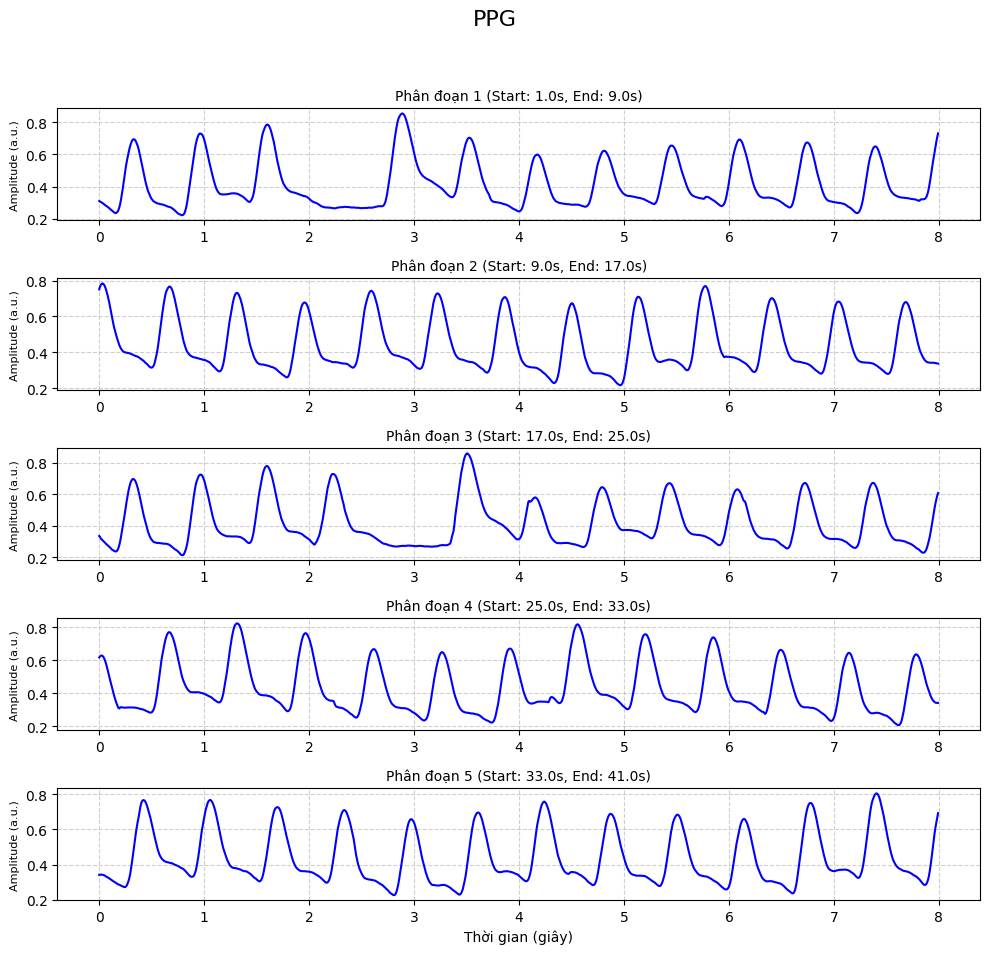

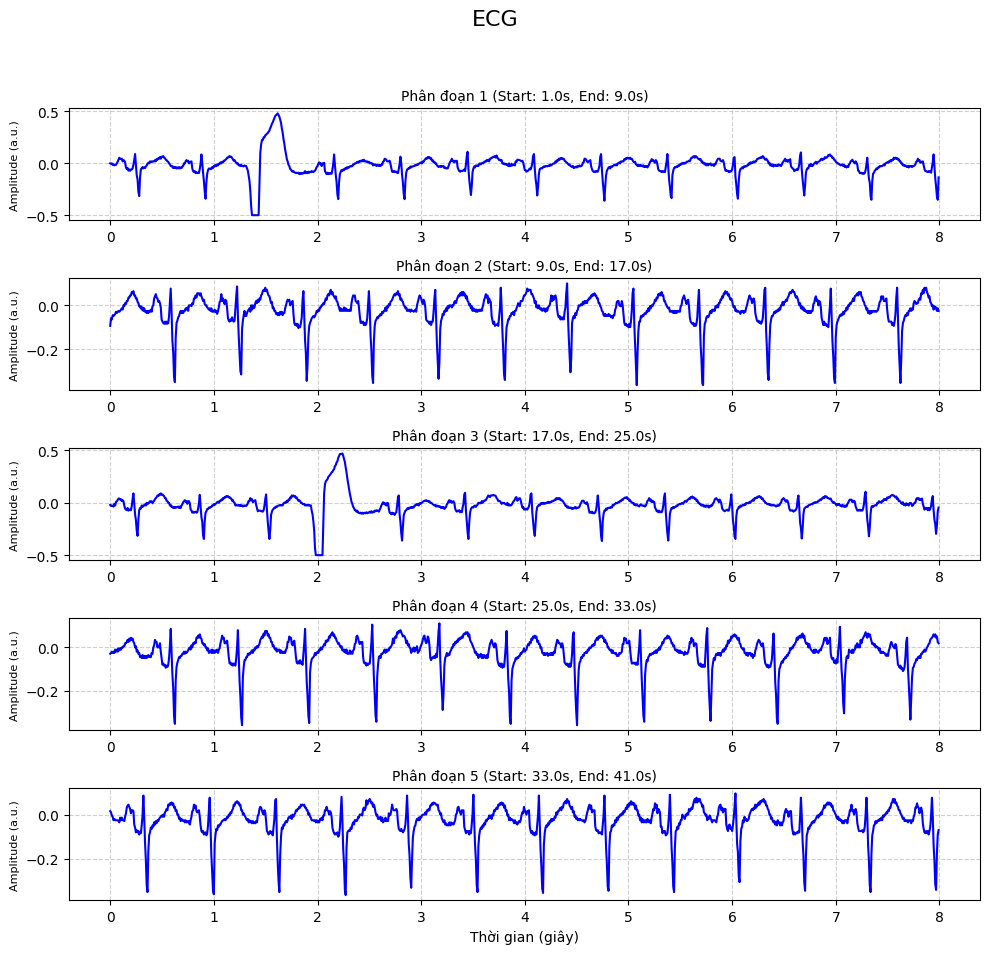

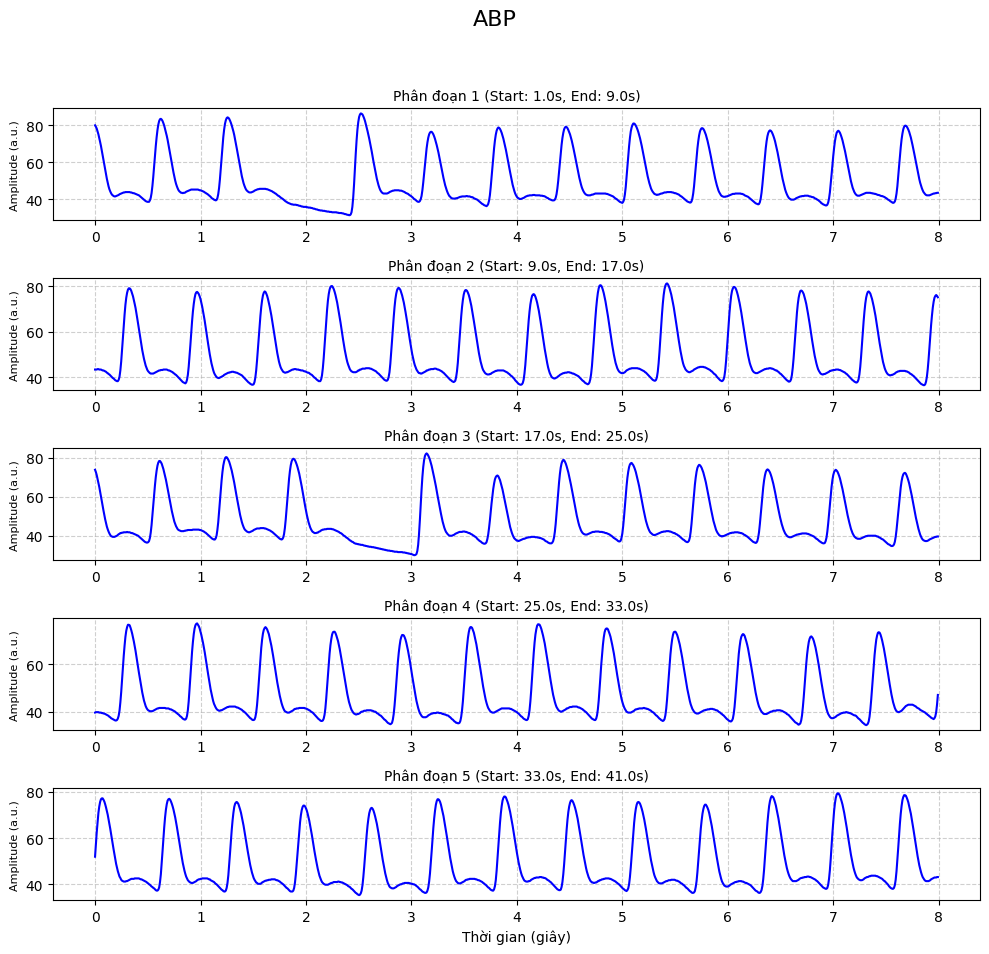

In [2]:
# === Đường dẫn file gộp và file đầu ra ===
input_path = r"D:\Python\data-ppg-ecg\MATLAB_preprocessing\data\combined_raw_data.h5"
output_path = r"D:\Python\data-ppg-ecg\MATLAB_preprocessing\data\data.h5"

# Đọc dữ liệu
with h5py.File(input_path, 'r') as f:
    print("📂 Dataset trong file:")
    f.visit(print) # Lệnh này sẽ in ra tên dataset thực tế!
    # 1. Truy cập các dataset bằng tên chính xác
    ppg_raw = f['PPG'][:]  # Lấy tín hiệu PPG (từ SPO2)
    abp_raw = f['ABP'][:]  # Lấy tín hiệu ABP
    ecg_raw = f['ECG'][:]  # Lấy tín hiệu ECG
    print(ppg_raw)
    print(ecg_raw)
    print(abp_raw)


fs = 125  # Sampling frequency (100 Hz)
duration = 60  # Total duration in seconds
time = np.arange(0, duration, 1/fs)

segment_length = 8 * fs
idx = [
    (1*fs, 1*fs + segment_length),
    (9*fs, 9*fs + segment_length),
    (17*fs, 17*fs + segment_length),
    (25*fs, 25*fs + segment_length),
    (33*fs, 33*fs + segment_length)
]

ppg_segments = [ppg_raw[s:e] for s, e in idx]
ecg_segments = [ecg_raw[s:e] for s, e in idx]
abp_segments = [abp_raw[s:e] for s, e in idx]

n_segments = 5
# Determine the layout for subplots (e.g., 5 segments -> 5x1 layout)
fig, axes = plt.subplots(n_segments, 1, figsize=(10, 2 * n_segments), sharex=False)
fig.suptitle('PPG', fontsize=16)

for i, segment in enumerate(ppg_segments):
    # Calculate time vector for the segment
    segment_time = np.arange(len(segment)) / fs
    
    # Plotting the segment
    ax = axes[i]
    ax.plot(segment_time, segment, color='b')
    ax.set_title(f'Phân đoạn {i+1} (Start: {idx[i][0]/fs:.1f}s, End: {idx[i][1]/fs:.1f}s)', fontsize=10)
    ax.set_ylabel('Amplitude (a.u.)', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Set common X-axis label for the bottom subplot
axes[-1].set_xlabel('Thời gian (giây)', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
#plt.savefig('PPG_RAW.png')
#print("PPG_RAW.png")



# Determine the layout for subplots (e.g., 5 segments -> 5x1 layout)
fig, axes = plt.subplots(n_segments, 1, figsize=(10, 2 * n_segments), sharex=False)
fig.suptitle('ECG', fontsize=16)

for i, segment in enumerate(ecg_segments):
    # Calculate time vector for the segment
    segment_time = np.arange(len(segment)) / fs
    
    # Plotting the segment
    ax = axes[i]
    ax.plot(segment_time, segment, color='b')
    ax.set_title(f'Phân đoạn {i+1} (Start: {idx[i][0]/fs:.1f}s, End: {idx[i][1]/fs:.1f}s)', fontsize=10)
    ax.set_ylabel('Amplitude (a.u.)', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Set common X-axis label for the bottom subplot
axes[-1].set_xlabel('Thời gian (giây)', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
#plt.savefig('ECG_RAW.png')
#print("ECG_RAW.png")
# --- 3. PLOT VISUALIZATION ---


# Determine the layout for subplots (e.g., 5 segments -> 5x1 layout)
fig, axes = plt.subplots(n_segments, 1, figsize=(10, 2 * n_segments), sharex=False)
fig.suptitle('ABP', fontsize=16)

for i, segment in enumerate(abp_segments):
    # Calculate time vector for the segment
    segment_time = np.arange(len(segment)) / fs
    
    # Plotting the segment
    ax = axes[i]
    ax.plot(segment_time, segment, color='b')
    ax.set_title(f'Phân đoạn {i+1} (Start: {idx[i][0]/fs:.1f}s, End: {idx[i][1]/fs:.1f}s)', fontsize=10)
    ax.set_ylabel('Amplitude (a.u.)', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Set common X-axis label for the bottom subplot
axes[-1].set_xlabel('Thời gian (giây)', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
#plt.savefig('ABP_RAW.png')
#print("ABP_RAW.png")


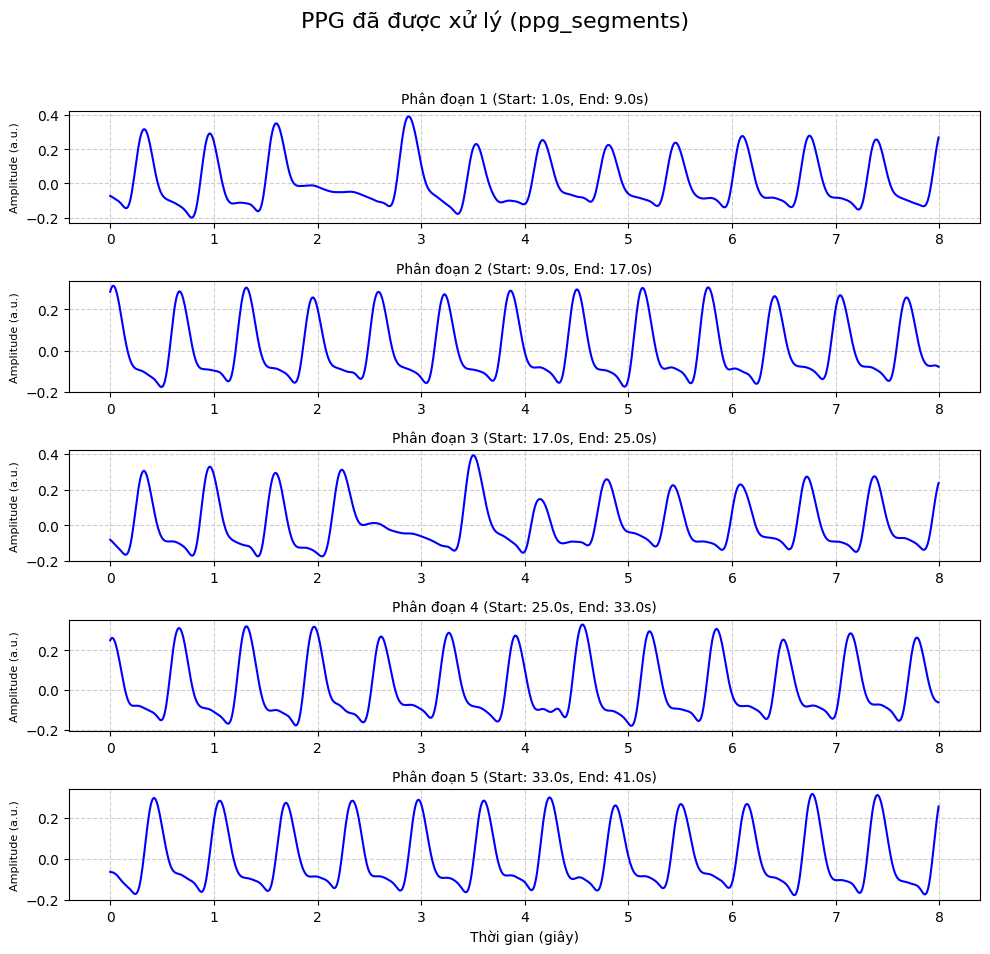

In [3]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# --- 1. GENERATE DUMMY DATA ---
fs = 125  
duration = 60  
time = np.arange(0, duration, 1/fs)


# Define segmentation indices (e.g., 5 segments of 5 seconds, skipping the ends)
segment_length = 8 * fs
idx = [
    (1*fs, 1*fs + segment_length),
    (9*fs, 9*fs + segment_length),
    (17*fs, 17*fs + segment_length),
    (25*fs, 25*fs + segment_length),
    (33*fs, 33*fs + segment_length)
]


def PPG_preprocessing(ppg_raw, fs):
    # --- Tiền xử lý PPG ---
    sos_ppg = signal.cheby2(4, 20, [0.5, 10], btype='bandpass', fs=fs, output='sos')
    ppg_f = signal.sosfiltfilt(sos_ppg, ppg_raw)
    x = np.arange(len(ppg_f))
    trend = np.polyval(np.polyfit(x, ppg_f, 3), x)
    ppg_final = ppg_f - trend
    return ppg_final    

ppg_f = PPG_preprocessing(ppg_raw, fs)
ppg_segments = [ppg_f[s:e] for s, e in idx]

# --- 3. PLOT VISUALIZATION ---
n_segments = 5

# Determine the layout for subplots (e.g., 5 segments -> 5x1 layout)
fig, axes = plt.subplots(n_segments, 1, figsize=(10, 2 * n_segments), sharex=False)
fig.suptitle('PPG đã được xử lý (ppg_segments)', fontsize=16)

for i, segment in enumerate(ppg_segments):
    # Calculate time vector for the segment
    segment_time = np.arange(len(segment)) / fs
    
    # Plotting the segment
    ax = axes[i]
    ax.plot(segment_time, segment, color='b')
    ax.set_title(f'Phân đoạn {i+1} (Start: {idx[i][0]/fs:.1f}s, End: {idx[i][1]/fs:.1f}s)', fontsize=10)
    ax.set_ylabel('Amplitude (a.u.)', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Set common X-axis label for the bottom subplot
axes[-1].set_xlabel('Thời gian (giây)', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
#plt.savefig('ppg_segments_visualization.png')
#print("ppg_segments_visualization.png")

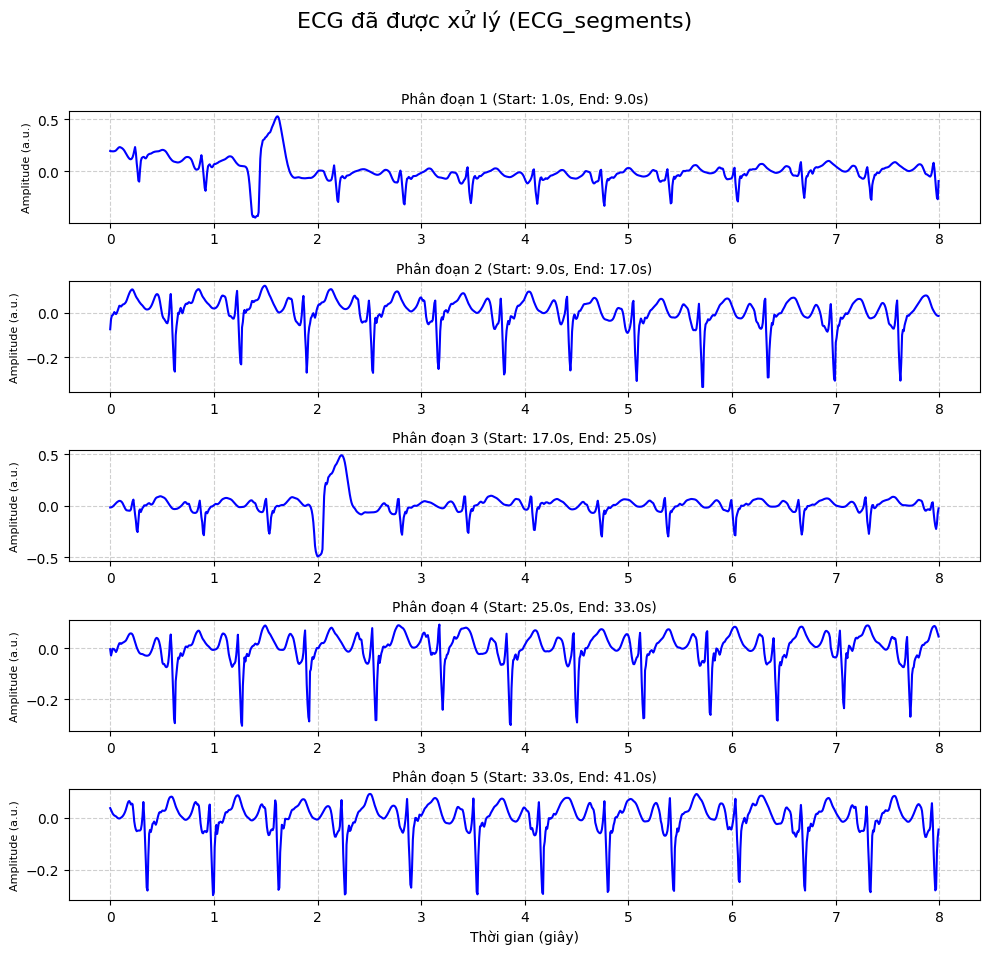

In [4]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# --- 1. GENERATE DUMMY DATA ---
fs = 125  # Sampling frequency (100 Hz)
duration = 30  # Total duration in seconds
time = np.arange(0, duration, 1/fs)


# Define segmentation indices (e.g., 5 segments of 5 seconds, skipping the ends)
segment_length = 8 * fs
idx = [
    (1*fs, 1*fs + segment_length),
    (9*fs, 9*fs + segment_length),
    (17*fs, 17*fs + segment_length),
    (25*fs, 25*fs + segment_length),
    (33*fs, 33*fs + segment_length)
]

def ECG_Preprocessing(ecg_raw, fs):
    # --- Tiền xử lý ECG ---
    sos_ecg = signal.butter(8, 0.1, btype='highpass', fs=fs, output='sos')
    ecg_hp = signal.sosfiltfilt(sos_ecg, ecg_raw)
    coeffs = pywt.wavedec(ecg_hp, 'db6', level=3, mode='symmetric')
    sigma = np.median(np.abs(coeffs[-1]))/0.6745
    thr = sigma*np.sqrt(2*np.log(len(ecg_hp)))
    coeffs[1:] = [pywt.threshold(c, thr, mode='soft') for c in coeffs[1:]]
    ecg_final = pywt.waverec(coeffs, 'db6', mode='symmetric')[:len(ecg_hp)]
    #savgol_filter(ecg_f, window_length=8, polyorder=1)
    return ecg_final

ecg_f = ECG_Preprocessing(ecg_raw, fs)

ecg_segments = [ecg_f[s:e] for s, e in idx]


# --- 3. PLOT VISUALIZATION ---
n_segments = 5

# Determine the layout for subplots (e.g., 5 segments -> 5x1 layout)
fig, axes = plt.subplots(n_segments, 1, figsize=(10, 2 * n_segments), sharex=False)
fig.suptitle('ECG đã được xử lý (ECG_segments)', fontsize=16)

for i, segment in enumerate(ecg_segments):
    # Calculate time vector for the segment
    segment_time = np.arange(len(segment)) / fs
    
    # Plotting the segment
    ax = axes[i]
    ax.plot(segment_time, segment, color='b')
    ax.set_title(f'Phân đoạn {i+1} (Start: {idx[i][0]/fs:.1f}s, End: {idx[i][1]/fs:.1f}s)', fontsize=10)
    ax.set_ylabel('Amplitude (a.u.)', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Set common X-axis label for the bottom subplot
axes[-1].set_xlabel('Thời gian (giây)', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
#plt.savefig('ecg_segments_visualization.png')
#print("ecg_segments_visualization.png")

In [5]:
# --- Tạo các đoạn tín hiệu cho PPG, ECG, ABP ---
ppg_segments1 = [ppg_f[s:e] for s, e in idx]
ecg_segments1 = [ecg_f[s:e] for s, e in idx]
abp_segments1 = [abp_raw[s:e] for s, e in idx]

In [6]:
import numpy as np
from scipy import signal

# Giả định: fs (tần số lấy mẫu) đã được định nghĩa
# fs = 125 

labels = []
for abp_seg in abp_segments:
    # ----------------------------------------------------
    # 1. TÌM ĐỈNH SBP (Cực đại)
    # ----------------------------------------------------
    
    # distance=int(0.27*fs) đảm bảo khoảng cách tối thiểu giữa 2 nhịp
    # prominence=np.std(abp_seg)*0.6 đảm bảo đỉnh nổi bật hơn nhiễu
    peaks_sbp, _ = signal.find_peaks(abp_seg, distance=int(0.27*fs), prominence=np.std(abp_seg)*0.6)
    
    if len(peaks_sbp) < 2:
        labels.append([np.nan, np.nan, np.nan])
        continue
        
    sbps = abp_seg[peaks_sbp]
    
    # ----------------------------------------------------
    # 2. TÌM ĐỈNH DBP (Cực tiểu) bằng cách ĐẢO NGƯỢC tín hiệu
    # ----------------------------------------------------
    
    # Đảo ngược tín hiệu: Cực tiểu trở thành Cực đại
    inverted_abp = -abp_seg
    
    # Tần số tim (nhịp/phút) sẽ giới hạn số lượng đỉnh DBP cần tìm. 
    # Ta sử dụng cùng các tham số tìm đỉnh như SBP.
    peaks_dbp, _ = signal.find_peaks(inverted_abp, distance=int(0.27*fs), prominence=np.std(inverted_abp)*0.6)
    
    # Lọc DBP: Đảm bảo số lượng DBP gần bằng SBP
    if len(peaks_dbp) < len(peaks_sbp) - 2 or len(peaks_dbp) > len(peaks_sbp) + 2:
        # Nếu không khớp, quay lại phương pháp tìm min giữa 2 SBP để đảm bảo kết quả
        dbps = []
        for i in range(len(peaks_sbp) - 1):
            a, b = peaks_sbp[i], peaks_sbp[i+1]
            dbps.append(np.min(abp_seg[a:b]))
    else:
        # DBP là giá trị của ABP tại các chỉ số tìm được
        dbps = abp_seg[peaks_dbp]

    # ----------------------------------------------------
    # 3. TÍNH TOÁN VÀ LƯU KẾT QUẢ
    # ----------------------------------------------------
    
    SBP = float(np.mean(sbps))
    # DBP trung bình chỉ tính trên các giá trị DBP hợp lệ (khi không rỗng)
    if len(dbps) > 0:
        DBP = float(np.mean(dbps))
    else:
        DBP = np.nan
        
    # Tính HR dựa trên đỉnh SBP (phương pháp ổn định hơn)
    HR = 60.0 / np.mean(np.diff(peaks_sbp) / fs)
    
    labels.append([SBP, DBP, HR])

labels = np.array(labels)
print(labels)


[[80.20026398 37.35329056 85.03401361]
 [78.73225403 37.66296005 94.07069555]
 [76.82235718 36.03768539 84.84162896]
 [74.59272766 35.90296936 92.69662921]
 [76.54199219 37.01129532 94.63722397]]


In [7]:
# --- Lưu kết quả ---
with h5py.File(output_path, 'w') as f:
    f.create_dataset('ppg_segments', data=ppg_segments1)
    f.create_dataset('ecg_segments', data=ecg_segments1)
    f.create_dataset('labels', data=labels)
print(f"Đã lưu segment và nhãn sau tiền xử lý vào {output_path}")

Đã lưu segment và nhãn sau tiền xử lý vào D:\Python\data-ppg-ecg\MATLAB_preprocessing\data\data.h5


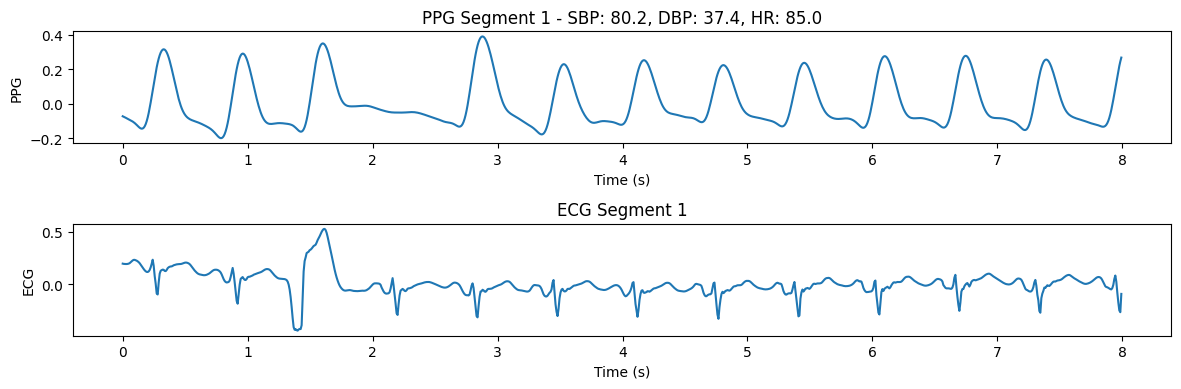

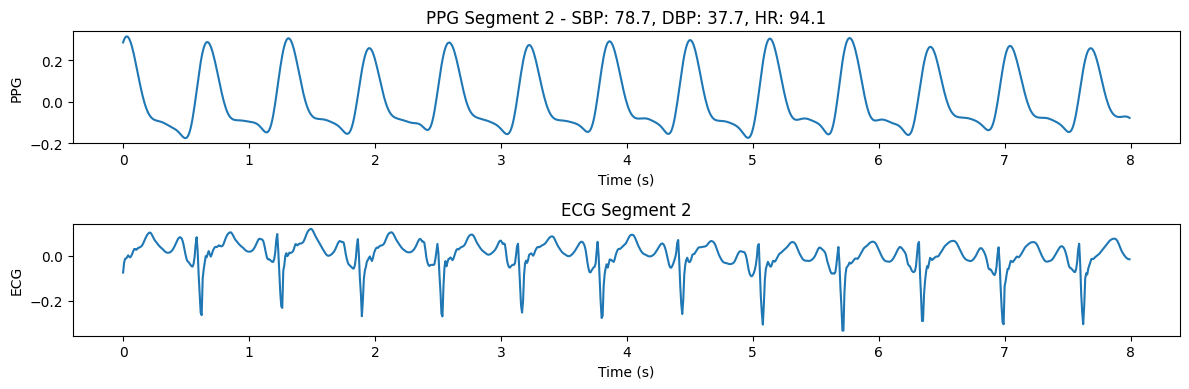

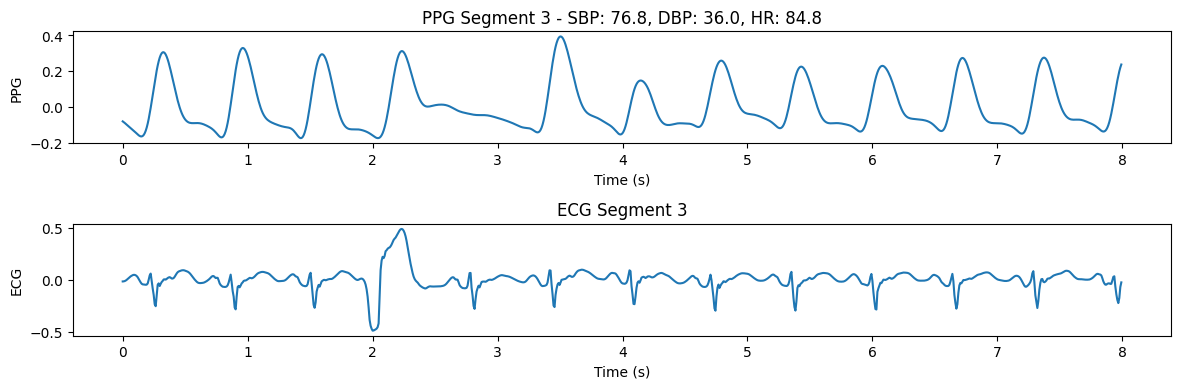

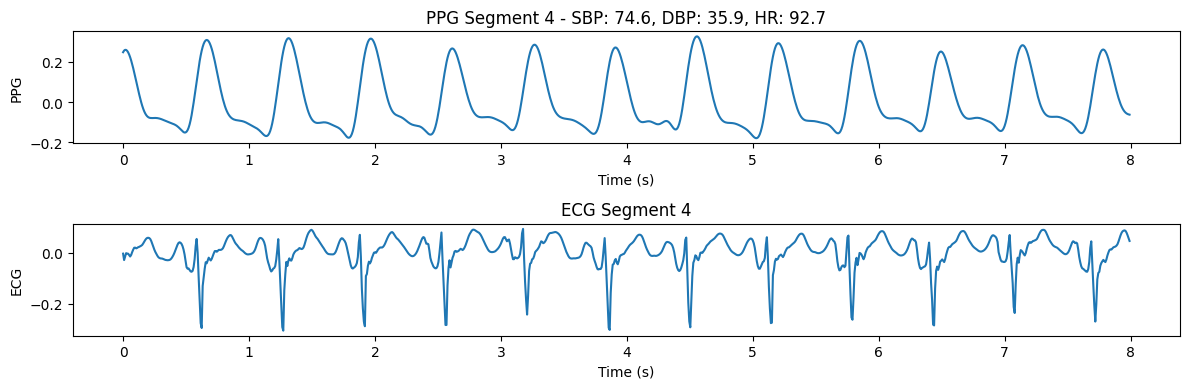

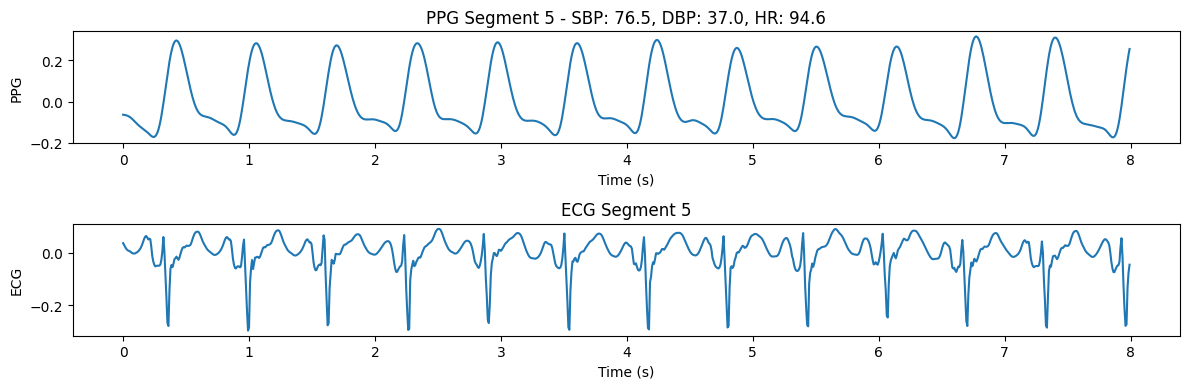

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


# Đường dẫn file đã xử lý
file_path = r"D:\Python\data-ppg-ecg\MATLAB_preprocessing\data\data.h5"

with h5py.File(file_path, 'r') as f:
    ppg_segments = f['ppg_segments'][:]
    ecg_segments = f['ecg_segments'][:]
    labels = f['labels'][:]




# Vẽ thử 2 segment đầu tiên
fs = 125
for i in range(5):
    plt.figure(figsize=(12,4))
    plt.subplot(2,1,1)
    plt.plot(np.arange(ppg_segments.shape[1])/fs, ppg_segments[i])
    plt.title(f"PPG Segment {i+1} - SBP: {labels[i,0]:.1f}, DBP: {labels[i,1]:.1f}, HR: {labels[i,2]:.1f}")
    plt.xlabel("Time (s)")
    plt.ylabel("PPG")
    plt.subplot(2,1,2)
    plt.plot(np.arange(ecg_segments.shape[1])/fs, ecg_segments[i])
    plt.title(f"ECG Segment {i+1}")
    plt.xlabel("Time (s)")
    plt.ylabel("ECG")
    plt.tight_layout()
    #plt.savefig("after preprocess{}.png".format(i))
    #print("after preprocess.png")